In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import brainsss
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
%matplotlib inline
plt.rcParams.update({'font.size': 20})
from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter
import nibabel as nib
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
from scipy.fftpack import fft,fftshift,ifft
import tqdm
import matplotlib

In [2]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"
### Load Supercluster Signals ###
file = os.path.join(cluster_dir, "20221202_SC_signals.npy")
supercluster_signals = np.load(file)
supercluster_signals = supercluster_signals.T
supercluster_signals.shape

(30456, 501)

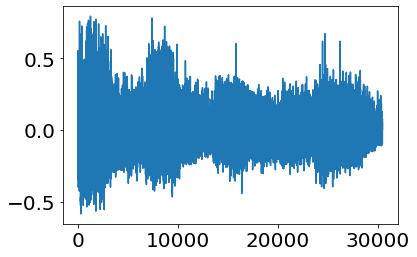

In [3]:
plt.plot(supercluster_signals[:,77])

In [4]:
supercluster_signals_fly = np.reshape(supercluster_signals,([9,3384,501]))

In [5]:
### for a given supercluster, i need to know the original median z-depth for each fly ###

dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']

z_corrections = []
for fly in tqdm.tqdm(fly_names):
    to_load = os.path.join(dataset_path, fly, 'warp', '20201220_warped_z_depth.nii')
    z_corrections.append(np.array(nib.load(to_load).get_data(), copy=True))
z_corrections = np.asarray(z_corrections)

superclusters_3d = np.load(os.path.join(cluster_dir, "20221130_pca_clsuters_in_luke_OG.npy"))
superclusters_3d = superclusters_3d[...,::-1] ### FLIP Z !!!!!!!!!!!!
superclusters_3d.shape

original_z_depth = []
for fly in tqdm.tqdm(range(9)):
    for cluster in range(501):
        ind = np.where(superclusters_3d==cluster)
        original_z_depth.append(np.median(z_corrections[fly,ind[0],ind[1],ind[2]]))
original_z_depth = np.asarray(original_z_depth)
original_z_depth = np.reshape(original_z_depth,(9,501))
original_z_depth = original_z_depth.astype('int')

100%|██████████| 9/9 [00:24<00:00,  2.68s/it]


In [6]:
### maybe the easiest way to do this is have a single behavior trace at original res (50Hz)
### I think it will be safest to use the raw neural data (not interpolated) and assign to bins

In [7]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"

In [8]:
fictrac = []
for fly in fly_names:
    
    fictrac_raw = brainsss.load_fictrac(os.path.join(dataset_path, fly, 'func_0', 'fictrac'))

    # Smooth raw fictrac data
    behavior = 'dRotLabZ'
    fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(fictrac_raw[behavior]),25,3)
    fps=50
    fictrac_smoothed = fictrac_smoothed * 180 / np.pi * fps # now in deg/sec
    fictrac.append(fictrac_smoothed)

In [9]:
fictrac_timestamps = np.arange(0,30*60*1000,20)
file = os.path.join(dataset_path, 'fly_087', 'func_0', 'imaging')
neural_timestamps = brainsss.load_timestamps(file)

Trying to load timestamp data from hdf5 file.
Success.


In [10]:
turn_thresh = 200

peaks_all_fly = []
peak_heights_all_fly = []
for fly in range(9):
    peaks = {'L':[],'R':[]}
    heights = {'L':[],'R':[]}
    for turn,scalar in zip(['L', 'R'],[1,-1]):
        
        found_peaks = scipy.signal.find_peaks(fictrac[fly]*scalar, height=turn_thresh)
        pks = found_peaks[0]
        pk_height = found_peaks[1]['peak_heights']
        
        ### remove peaks that are too close to beginning or end
        # will do 20sec window
        # here 20sec is 1000 tps
        ind = np.where(pks>88000)[0]
        pks = np.delete(pks,ind)
        pk_height = np.delete(pk_height,ind)
        
        ind = np.where(pks<2000)[0]
        pks = np.delete(pks,ind)
        pk_height = np.delete(pk_height,ind)
        
        peaks[turn] = pks
        heights[turn] = pk_height
    peaks_all_fly.append(peaks)
    peak_heights_all_fly.append(heights)

In [11]:
243+250

493

In [14]:
##################################################
### VERSION WITH FIRST NEURAL POINT AFTER TURN ###
##################################################

#final [ 77, 106, 185, 186, 203]

neural_traces_all_fly = []
for fly in range(9):
    neural_traces = {'L77': [], 'R77': [], 'L327': [], 'R327': []}
    for cluster, cluster_real in zip([77,327], [77,327]):#[77,327]:
        z = original_z_depth[fly,cluster_real]
        neural_timestamps_cluster = neural_timestamps[:,z]
        for beh in ['L', 'R']:
            peaks_in_ms = fictrac_timestamps[peaks_all_fly[fly][beh]]
            for peak in peaks_in_ms:
                #this will give the index of the first neural data after the peak
                # 40 index will be the bin from 0 to 532ms after the peak
                middle = np.searchsorted(neural_timestamps_cluster,peak) 
                neural_traces[F"{beh}{cluster}"].append(supercluster_signals_fly[fly,middle-40:middle+40,cluster_real])
            neural_traces[F"{beh}{cluster}"] = np.asarray(neural_traces[F"{beh}{cluster}"])
    neural_traces_all_fly.append(neural_traces)
    
neural_traces_all_fly_stack = {'L77': [], 'R77': [], 'L327': [], 'R327': []}
for signal in ['L77','R77','L327','R327']:
    for fly in range(9):
        neural_traces_all_fly_stack[signal].extend(neural_traces_all_fly[fly][signal])
    neural_traces_all_fly_stack[signal] = np.asarray(neural_traces_all_fly_stack[signal])

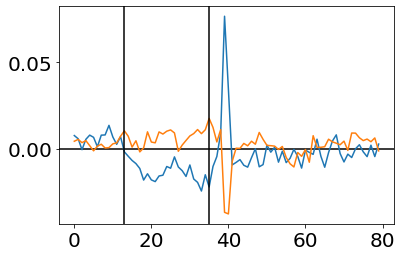

In [208]:
plt.axhline(0,color='k')
plt.plot(np.mean(neural_traces_all_fly_stack['L77']-neural_traces_all_fly_stack['L327'],axis=0))
plt.plot(np.mean(neural_traces_all_fly_stack['R77']-neural_traces_all_fly_stack['R327'],axis=0))
plt.axvline(13,color='k')
plt.axvline(35,color='k')

In [15]:
diff_L = neural_traces_all_fly_stack['L77'] - neural_traces_all_fly_stack['L327']
diff_R = neural_traces_all_fly_stack['R77'] - neural_traces_all_fly_stack['R327']
diff_L.shape, diff_R.shape

((1362, 80), (2424, 80))

In [159]:
to_cluster = diff_R

In [232]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"

t0 = time.time()
print('clustering.........')
n_clusters = 10
model = AgglomerativeClustering(distance_threshold=0, #first run with =0. Then change to None
                                n_clusters=None, #and with n_clusters =None. Then change to n_clusters
                                memory=cluster_dir,
                                linkage='ward')
model = model.fit(to_cluster)
print('complete!')
print(time.time()-t0)

clustering.........
complete!
0.07184934616088867


In [34]:
len(model.labels_)

1362

In [20]:
cmap = matplotlib.cm.get_cmap('gist_ncar')
colors_manual = cmap(np.linspace(0,1,n_clusters))

In [ ]:
cluster_hists = []
for label in np.unique(model.labels_):
    ind = np.where(model.labels_==label)[0]
    cluster_hists.append(np.mean(hist_3d[ind,0,...],axis=0))

array([1285,  725, 1223, ...,    3,    1,    0])

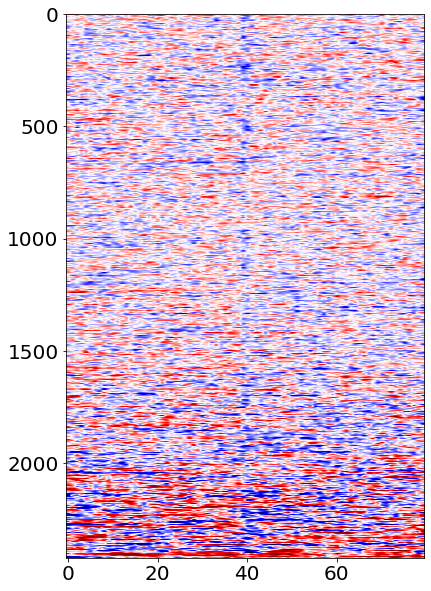

In [99]:
plt.figure(figsize=(10,10))
plt.imshow(to_cluster[model.labels_,:],aspect=0.05,vmin=-.3,vmax=.3,cmap='seismic',interpolation='gaussian')

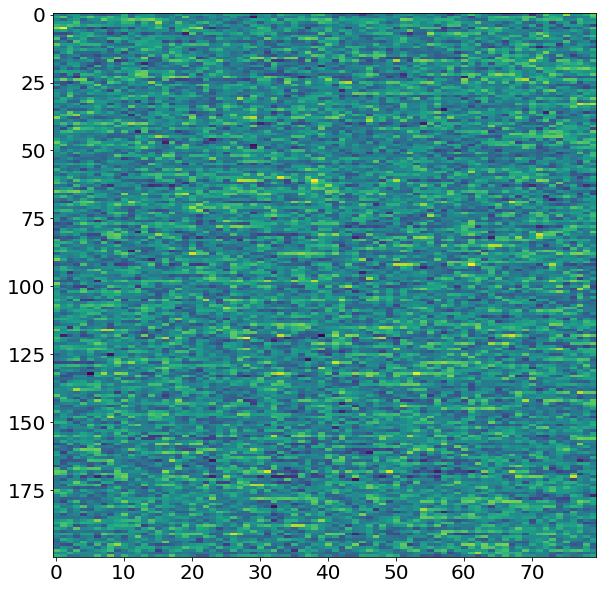

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(to_cluster[model.labels_[:200],:],aspect=0.4)

In [32]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from matplotlib import colors

In [33]:
to_cluster.shape

(1362, 80)

In [82]:
t0 = time.time()
print('clustering.........')
model = AgglomerativeClustering(distance_threshold=0, #first run with =0. Then change to None
                                n_clusters=None, #and with n_clusters =None. Then change to n_clusters
                                memory=cluster_dir,
                                linkage='ward')
model = model.fit(to_cluster)
print('complete!')
print(time.time()-t0)

clustering.........
complete!
0.019974231719970703


In [83]:
### Create linkage matrix for dendrogram

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, model.distances_,
                                  counts]).astype(float)

In [84]:
n_clusters = 5

### Given a desired # of clusters, grab the distance threshold - needed for dendrogram
thresh = model.distances_[-n_clusters+1]

### Create the same # of colors as # of clusters
custom_cmap = cm.gist_ncar(np.linspace(0.1, 0.95, n_clusters))
cluster_colors = [colors.rgb2hex(rgb[:3]) for rgb in custom_cmap]
hierarchy.set_link_color_palette(cluster_colors[::-1])

### Grab the cluster ids
cluster_ids = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
cluster_ids -= 1 #make 0 index

cluster_colors_for_brain = cluster_colors[:]
#cluster_colors_for_brain.insert(0,'grey')
cmap = colors.ListedColormap(cluster_colors_for_brain)

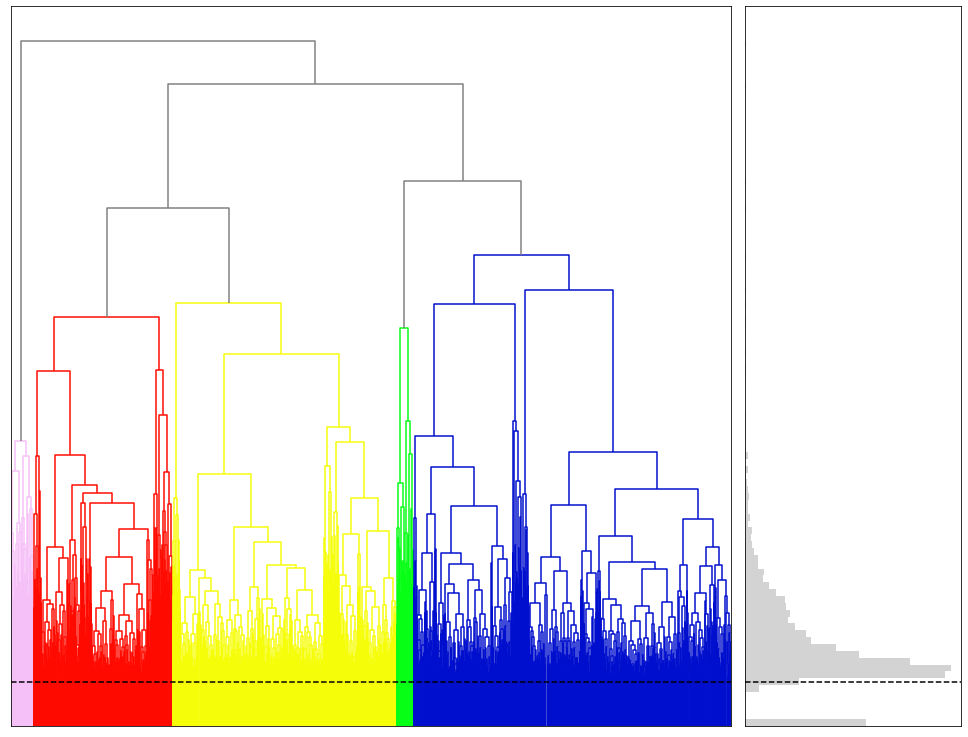

In [85]:
fig = plt.figure(figsize=(10,10))
background_color = '#D3D3D3'

ax_dendrogram = fig.add_axes([1.1, 0, 1, 1])
ax_dendrogram.get_xaxis().set_visible(False)
ax_dendrogram.get_yaxis().set_visible(False)
dendrogram(linkage_matrix,
           truncate_mode=None,
           p=0,
           color_threshold=thresh,
           no_labels=True,
           distance_sort=True,
           above_threshold_color='grey');
try:
    plt.axhline(linkage_matrix[251-n_clusters,2],color='k',linestyle='--')
except:
    print('axhline failed')

ax_dend_hist = fig.add_axes([2.12, 0, .3, 1],sharey=ax_dendrogram)
ax_dend_hist.hist(linkage_matrix[:,2],bins=100,orientation='horizontal',color=background_color);
try:
    ax_dend_hist.axhline(linkage_matrix[251-n_clusters,2],color='k',linestyle='--')
except:
    print('axhline failed')
ax_dend_hist.get_xaxis().set_visible(False)
ax_dend_hist.get_yaxis().set_visible(False)

clustering.........
complete!
0.047617435455322266


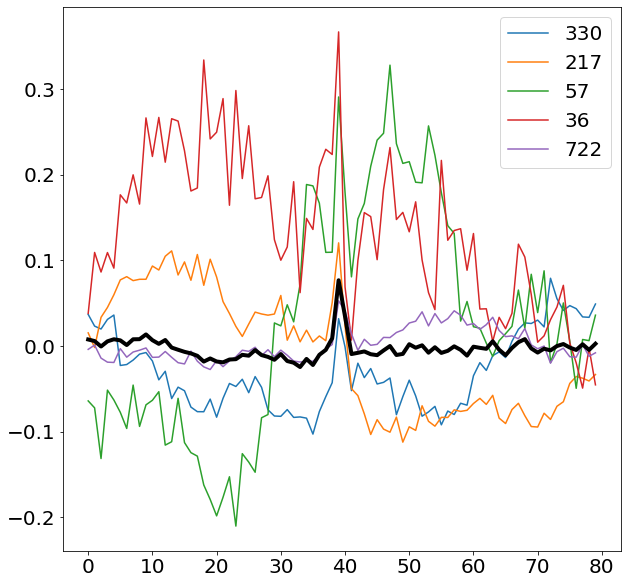

In [14]:
to_cluster = diff_L
n_clusters = 5
t0 = time.time()
print('clustering.........')
model = AgglomerativeClustering(distance_threshold=None, #first run with =0. Then change to None
                                n_clusters=n_clusters, #and with n_clusters =None. Then change to n_clusters
                                memory=cluster_dir,
                                linkage='ward')
model = model.fit(to_cluster)
print('complete!')
print(time.time()-t0)

plt.figure(figsize=(10,10))
cluster_means = []
for label in np.unique(model.labels_):
    ids = np.where(model.labels_==label)[0]
    cluster_means.append(np.mean(to_cluster[ids,:],axis=0))
    plt.plot(cluster_means[label],label=len(ids))

plt.plot(np.mean(diff_L,axis=0),color='k',lw=4)
plt.legend()

In [15]:
to_cluster.shape

(1362, 80)

In [234]:
diff_L = neural_traces_all_fly_stack['L77'] - neural_traces_all_fly_stack['L327']
diff_R = neural_traces_all_fly_stack['R77'] - neural_traces_all_fly_stack['R327']
diff_L.shape, diff_R.shape

((1362, 80), (2424, 80))

In [71]:
np.max(neural_traces_all_fly_stack['L77'])

0.7930723947403175

In [24]:
L_con = np.concatenate((neural_traces_all_fly_stack['L77'],neural_traces_all_fly_stack['L327']),axis=1)
L_con.shape

(1362, 160)

In [39]:
np.mean(to_cluster,axis=1).shape, to_cluster.shape

((1362,), (1362, 80))

In [42]:
s.shape

(1362,)

clustering.........
complete!
0.14972543716430664


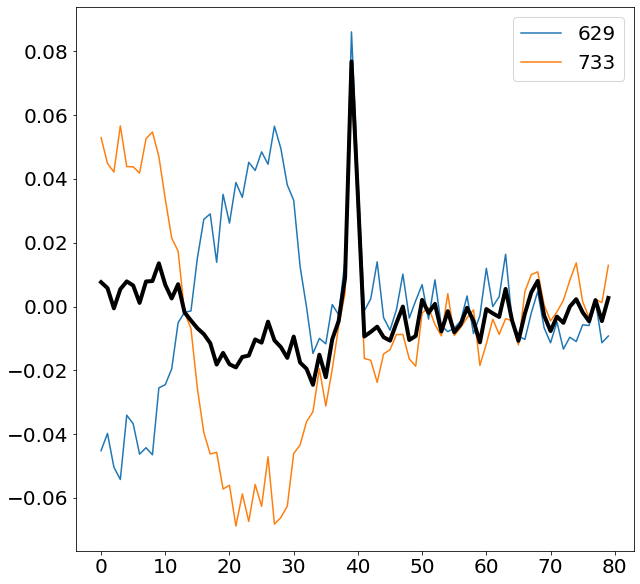

In [16]:
to_cluster = diff_L

m = np.mean(to_cluster[:,:35],axis=1)
s = np.std(to_cluster[:,:35],axis=1)
to_cluster = (to_cluster-m[:,np.newaxis])/s[:,np.newaxis]

n_clusters = 2
t0 = time.time()
print('clustering.........')
model = AgglomerativeClustering(distance_threshold=None, #first run with =0. Then change to None
                                n_clusters=n_clusters, #and with n_clusters =None. Then change to n_clusters
                                memory=cluster_dir,
                                linkage='ward')
model = model.fit(to_cluster[:,:35])
print('complete!')
print(time.time()-t0)

plt.figure(figsize=(10,10))
cluster_means = []
for label in np.unique(model.labels_):
    ids = np.where(model.labels_==label)[0]
    cluster_means.append(np.mean(diff_L[ids,:],axis=0))
    plt.plot(cluster_means[label],label=len(ids))

plt.plot(np.mean(diff_L,axis=0),color='k',lw=4)
plt.legend()
#plt.title('cluster 243')

In [26]:
### How do these two clusters compare to individual trace predictions of L vs R turn

thresh = 0
L = np.mean(diff_L[:,12:30],axis=1)
turn_prediction = (L<thresh)*1

agree = []
for i in range(1362):
    if turn_prediction[i] == model.labels_[i]:
        agree.append(True)
    else:
        agree.append(False)

In [28]:
np.sum(agree)/1362

0.6747430249632893

In [29]:
733/1362

0.5381791483113069

In [32]:
np.sum(turn_prediction)/1362

0.5521292217327459

In [236]:
cluster_243_L_labels = model.labels_.copy()

In [227]:
cluster_248_L_labels = model.labels_.copy()

In [217]:
cluster_27_L_labels = model.labels_.copy()

In [161]:
cluster_203_L_labels = model.labels_.copy()

In [149]:
cluster_186_L_labels = model.labels_.copy()

In [140]:
cluster_185_L_labels = model.labels_.copy()

In [128]:
cluster_77_L_labels

array([0, 0, 0, ..., 1, 0, 1])

In [241]:
labels = {'27': cluster_27_L_labels,
          '248': cluster_248_L_labels,
          '243': cluster_243_L_labels,
          '77': cluster_77_L_labels,
          '185': cluster_185_L_labels,
          '186': cluster_186_L_labels,
          '106': cluster_106_L_labels,
          '203': cluster_203_L_labels}

# file = os.path.join(cluster_dir, '20230405_confusion_matrix_L')
# np.save(file, labels, allow_pickle=True)

(-0.5, 7.5)

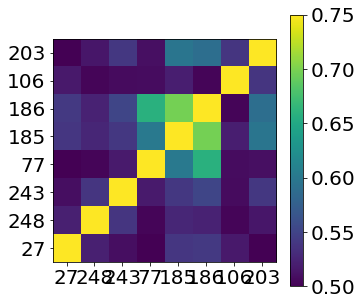

In [242]:
agreements = []
for label_1 in list(labels.keys()):
    for label_2 in list(labels.keys()):
        agree = []
        for i in range(1362):
            if labels[label_1][i] == labels[label_2][i]:
                agree.append(True)
            else:
                agree.append(False)
        a = np.sum(agree)/1362
        if a < 0.5:
            a = 1-a
        agreements.append(a)

plt.figure(figsize=(5,5))
plt.imshow(np.reshape(np.asarray(agreements),(8,8)),vmin=.5,vmax=.75)
plt.colorbar()
plt.yticks([0,1,2,3,4,5,6,7],list(labels.keys()));
plt.xticks([0,1,2,3,4,5,6,7],list(labels.keys()));
plt.ylim(-.5,7.5)

In [154]:
agree = []
for i in range(len(cluster_77_L_labels)):
    if cluster_186_L_labels[i] == cluster_185_L_labels[i]:
        agree.append(True)
    else:
        agree.append(False)
        
np.sum(agree)/len(cluster_106_L_labels)

0.697503671071953

0.4919236417033774

In [119]:
cluster_106_L_labels = model.labels_.copy()

In [109]:
cluster_77_L_labels = model.labels_.copy()

In [91]:
fictrac[0].shape

(90000,)

In [89]:
window = 1500
beh_traces_L = []
beh_traces_R = []

for fly in range(9):
    
    beh_traces_L_fly = []
    beh_traces_R_fly = []
    
    for beh in ['L', 'R']:
        peaks_in_ms = peaks_all_fly[fly][beh]
        for peak in peaks_in_ms:
            bout = fictrac[fly][peak-window:peak+window]
            if beh == 'L':
                beh_traces_L_fly.append(bout)
            elif beh == 'R':
                beh_traces_R_fly.append(bout)
                
    beh_traces_L.append(np.asarray(beh_traces_L_fly))
    beh_traces_R.append(np.asarray(beh_traces_R_fly))
    
beh_traces_L_stacked = np.empty((0,window*2))
beh_traces_R_stacked = np.empty((0,window*2))
for fly in range(9):
    beh_traces_L_stacked = np.concatenate((beh_traces_L_stacked, beh_traces_L[fly]))
    beh_traces_R_stacked = np.concatenate((beh_traces_R_stacked, beh_traces_R[fly]))

In [90]:
beh_traces_L_stacked.shape

(1362, 3000)

In [95]:
800*20

16000

In [ ]:
## fictrac is 20ms bins
# 1500 is 0
# 1400 would be -2sec
# 700 would be -16

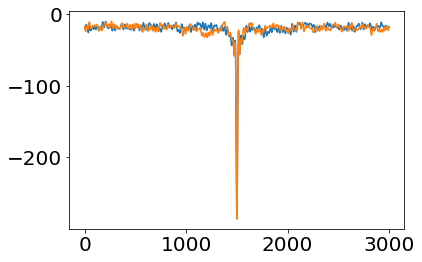

In [106]:
label = 0
ids = np.where(model.labels_==label)[0]
beh = np.mean(beh_traces_R_stacked[ids,:],axis=0)
plt.plot(beh)

label = 1
ids = np.where(model.labels_==label)[0]
beh = np.mean(beh_traces_R_stacked[ids,:],axis=0)
plt.plot(beh)

In [97]:
label = 0
ids = np.where(model.labels_==label)[0]
np.mean(beh_traces_L_stacked[ids,700:1400])

-0.6428374788978726

In [58]:
np.unique(model.labels_)

array([0, 1])

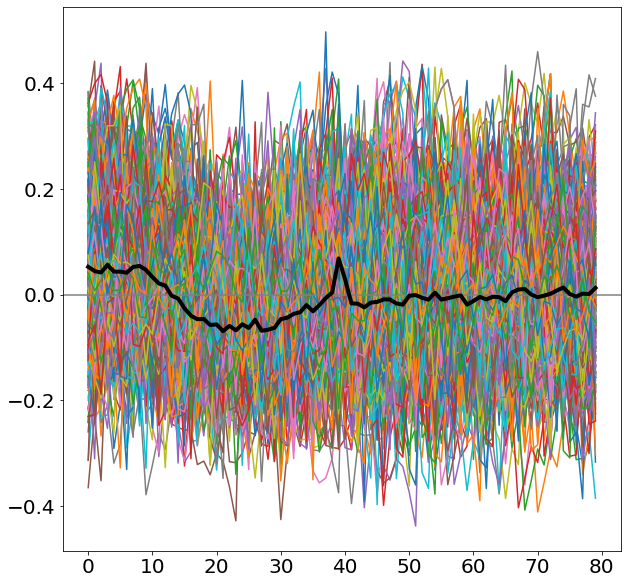

In [82]:
plt.figure(figsize=(10,10))
cluster_means = []
label = 1
ids = np.where(model.labels_==label)[0]
for id_ in ids:
    m = np.mean(diff_L[id_,:])
    s = np.std(diff_L[id_,:])
    plt.plot((diff_L[id_,:]-m)/2)
plt.axhline(0,color='grey')

plt.plot(np.mean(diff_L[ids,:],axis=0),color='k',lw=4)

#plt.plot(np.mean(diff_L,axis=0),color='k',lw=4)
#plt.legend()

In [83]:
733/(629+733)

0.5381791483113069

In [84]:
1375/(1375+1049)

0.5672442244224423

clustering.........
complete!
0.11560678482055664


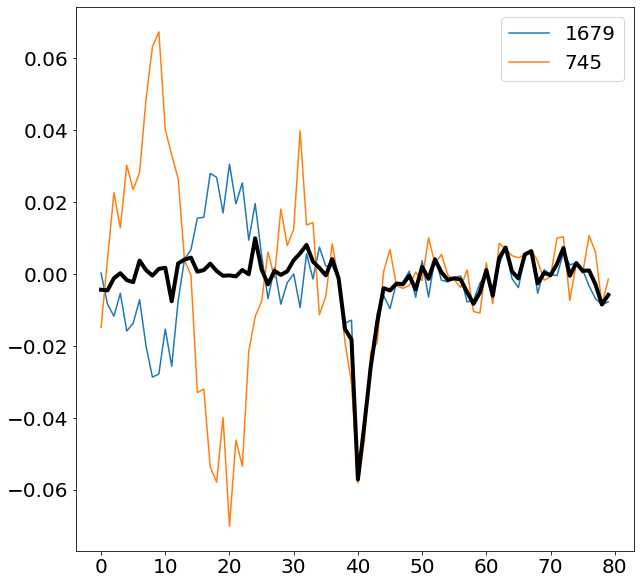

In [162]:
to_cluster = diff_R

m = np.mean(to_cluster[:,:35],axis=1)
s = np.std(to_cluster[:,:35],axis=1)
to_cluster = (to_cluster-m[:,np.newaxis])/s[:,np.newaxis]

n_clusters = 2
t0 = time.time()
print('clustering.........')
model = AgglomerativeClustering(distance_threshold=None, #first run with =0. Then change to None
                                n_clusters=n_clusters, #and with n_clusters =None. Then change to n_clusters
                                memory=cluster_dir,
                                linkage='ward')
model = model.fit(to_cluster[:,:35])
print('complete!')
print(time.time()-t0)

plt.figure(figsize=(10,10))
cluster_means = []
for label in np.unique(model.labels_):
    ids = np.where(model.labels_==label)[0]
    cluster_means.append(np.mean(diff_R[ids,:],axis=0))
    plt.plot(cluster_means[label],label=len(ids))

plt.plot(np.mean(diff_R,axis=0),color='k',lw=4)
plt.legend()

In [163]:
cluster_203_R_labels = model.labels_.copy()

In [151]:
cluster_186_R_labels = model.labels_.copy()

In [143]:
cluster_185_R_labels = model.labels_.copy()

In [134]:
cluster_106_R_labels = model.labels_.copy()

In [111]:
cluster_77_R_labels = model.labels_.copy()

In [166]:
agree = []
for i in range(len(cluster_77_R_labels)):
    if cluster_77_R_labels[i] == cluster_203_R_labels[i]:
        agree.append(True)
    else:
        agree.append(False)
        
np.sum(agree)/len(cluster_106_R_labels)

0.5115511551155115

In [204]:
labels = {'77': cluster_77_R_labels,
          '185': cluster_185_R_labels,
          '186': cluster_186_R_labels,
          '106': cluster_106_R_labels,
          '203': cluster_203_R_labels}

# file = os.path.join(cluster_dir, '20230405_confusion_matrix_R')
# np.save(file, labels, allow_pickle=True)

In [205]:
agreements = []
for label_1 in list(labels.keys()):
    for label_2 in list(labels.keys()):
        agree = []
        for i in range(2424):
            if labels[label_1][i] == labels[label_2][i]:
                agree.append(True)
            else:
                agree.append(False)
        agreements.append(np.sum(agree)/2424)

(-0.5, 4.5)

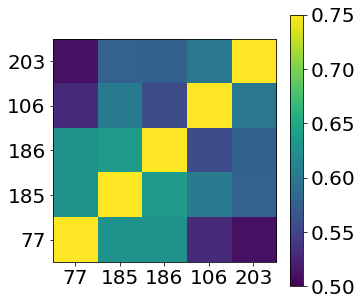

In [206]:
plt.figure(figsize=(5,5))
plt.imshow(np.reshape(np.asarray(agreements),(5,5)),vmin=.5,vmax=.75)
plt.colorbar()
plt.yticks([0,1,2,3,4],list(labels.keys()));
plt.xticks([0,1,2,3,4],list(labels.keys()));
plt.ylim(-.5,4.5)

In [170]:
len(cluster_77_R_labels)

2424

clustering.........
complete!
0.12513351440429688


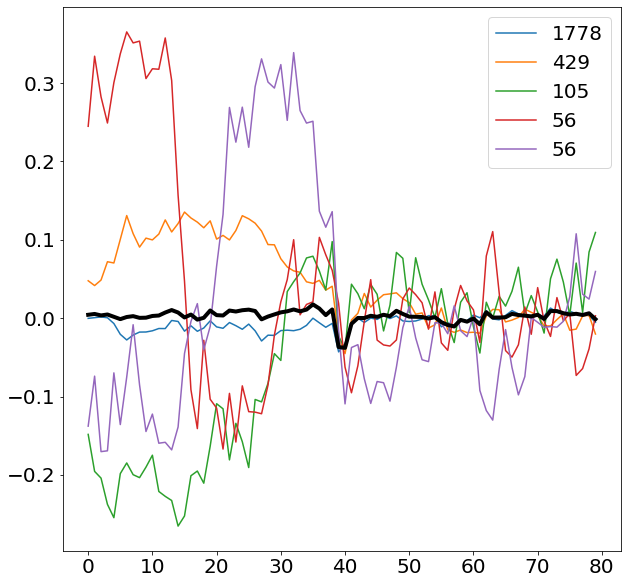

In [33]:
to_cluster = diff_R
n_clusters = 5
t0 = time.time()
print('clustering.........')
model = AgglomerativeClustering(distance_threshold=None, #first run with =0. Then change to None
                                n_clusters=n_clusters, #and with n_clusters =None. Then change to n_clusters
                                memory=cluster_dir,
                                linkage='ward')
model = model.fit(to_cluster[:,:35])
print('complete!')
print(time.time()-t0)

plt.figure(figsize=(10,10))
cluster_means = []
for label in np.unique(model.labels_):
    ids = np.where(model.labels_==label)[0]
    cluster_means.append(np.mean(to_cluster[ids,:],axis=0))
    plt.plot(cluster_means[label],label=len(ids))

plt.plot(np.mean(diff_R,axis=0),color='k',lw=4)
plt.legend()